## Weather Classification Monitoring with Prometheus & Grafana

This project focuses on classifying weather conditions into 4 categories: **Rainy**, **Sunny**, **Cloudy** and **Snowy**.

The main goal of this project is not only to train a NN, but also to learn how to monitor ML training in real time using **Prometheus** and **Grafana**.

The classification is based on several weather-related features, such as:
- **Temperature** *(numeric)*: The temperature in degrees Celsius, ranging from extreme cold to extreme heat
- **Humidity** *(numeric)*: The humidity percentage, including values above 100% to introduce outliers
- **Wind Speed** *(numeric)*: The wind speed in kilometers per hour, with a range including unrealistically high values
- **Precipitation (%)** *(numeric)*: The precipitation percentage, including outlier values
- **Cloud Cover** *(categorical)*: The cloud cover description
- **Atmospheric Pressure** *(numeric)*: The atmospheric pressure in hPa, covering a wide range
- **UV Index** (*numeric)*: The UV index, indicating the strength of ultraviolet radiation
- **Season** *(categorical)*: The season during which the data was recorded
- **Visibility (km)** *(numeric)*: The visibility in kilometers, including very low or very high values
- **Location** *(categorical)*: The type of location where the data was recorded
- **Weather Type** *(categorical)*: The target variable for classification, indicating the weather type

Dataset can be found on **Kaggle**:
- https://www.kaggle.com/datasets/nikhil7280/weather-type-classification
- or locally as `weather_classification_data.csv`.


### Project Overview

**1. Dataset**

- Tabular weather dataset stored in a CSV file
- Numerical features are standardized using **StandardScaler**
- Categorical labels are encoded into numerical classes

**2. Model**

- A fully connected NN built with **PyTorch**
- Two hidden layers with **ReLU** activations
- Cross-entropy loss for multi-class classification

**3. Training & Evaluation**

- Multiple (**12**) optimization algorithms from PyTorch optim were tested
- **Adam** achieved the best overall performance and was selected
- Model evaluation includes:
    - Classification report (precision, recall, F1-score)
    - Confusion matrix
    - Training and validation curves for accuracy and loss

**4. Monitoring with Prometheus & Grafana**

- The following metrics are exported to Prometheus during training:
    - Training loss
    - Validation loss
    - Training accuracy
    - Validation accuracy
- Prometheus
    - Metrics endpoint: http://localhost:8000/
    - Prometheus UI: http://localhost:9090/
- Grafana
    - Grafana dashboard: http://localhost:3000/
    - Used to visualize training and validation performance in real time

### 1. Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from prometheus_client import start_http_server, Gauge

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random

### 2. Configuration

In [2]:
# Fixing a random seed for consistent results
RANDOM_SEED = 42

# Training hyperparameter
BATCH_SIZE = 32

# Device config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 3. Seed Function

This function ensures reproducibility across Python, NumPy and PyTorch, making this experiment more consistent.

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(RANDOM_SEED)

### 4. Dataset

In [4]:
# Load CSV
df = pd.read_csv("weather_classification_data.csv")

# Indentify target and features
target_col = 'Weather Type'
feature_cols = [c for c in df.columns if c != target_col]

# Separate features and target
X = df[feature_cols]
y = df[target_col]

# Encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns.to_list()
if categorical_cols:
    X = pd.get_dummies(X, columns=categorical_cols)

# Encode target
le = LabelEncoder()
y = le.fit_transform(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Custom PyTorch Dataset
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_dataset = WeatherDataset(X_train, y_train)
test_dataset = WeatherDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

### 5. Model

In [ ]:
# Simple fully connected NN
class WeatherClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = len(le.classes_)

model = WeatherClassifier(input_dim, hidden_dim, output_dim).to(DEVICE)

### 6. Prometheus Metrics

In [ ]:
# Start Prometheus server on port 8000 | http://localhost:8000/
start_http_server(8000)

# Metrics
TRAIN_LOSS = Gauge('weather_train_loss', 'Training loss')
VAL_LOSS = Gauge('weather_val_loss', 'Validation loss')
TRAIN_ACC = Gauge('weather_train_accuracy', 'Training accuracy')
VAL_ACC = Gauge('weather_val_accuracy', 'Validation accuracy')

### 7. Training Loop

In [7]:
def train_model(model, optimizer, criterion, dataloaders, num_epochs=20):
    best_acc = 0.0  # Track best validation accuracy
    best_model_wts = model.state_dict()  # Save best model weights
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        # --- TRAINING LOOP ---
        model.train()
        train_loss, corrects = 0.0, 0
        for inputs, labels in dataloaders["train"]:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels)

        train_loss /= len(dataloaders["train"].dataset)
        train_acc = corrects.double() / len(dataloaders["train"].dataset)

        # --- VALIDATION LOOP ---
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in dataloaders["val"]:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels)

        val_loss /= len(dataloaders["val"].dataset)
        val_acc = val_corrects.double() / len(dataloaders["val"].dataset)

        # Update Prometheus metrics
        TRAIN_LOSS.set(train_loss)
        TRAIN_ACC.set(train_acc.item())
        VAL_LOSS.set(val_loss)
        VAL_ACC.set(val_acc.item())

        # Save history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc.item())
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc.item())

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

### 8. Evaluation Function

In [ ]:
def evaluate_model(model, dataloaders, classes):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloaders["test"]:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    unique_labels = sorted(set(y_true) | set(y_pred))
    
    # Print classification metrics
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, labels=unique_labels,
                                target_names=[classes[i] for i in unique_labels], zero_division=0))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
    
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=[classes[i] for i in unique_labels],
                yticklabels=[classes[i] for i in unique_labels],
                cmap="Blues")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()

    return y_true, y_pred

### 9. Train and Evaluate Model

Epoch 1/50 | Train Loss: 0.5312, Train Acc: 0.8360, Val Loss: 0.3347, Val Acc: 0.8902
Epoch 2/50 | Train Loss: 0.2924, Train Acc: 0.8958, Val Loss: 0.2769, Val Acc: 0.8973
Epoch 3/50 | Train Loss: 0.2513, Train Acc: 0.9021, Val Loss: 0.2484, Val Acc: 0.9027
Epoch 4/50 | Train Loss: 0.2284, Train Acc: 0.9090, Val Loss: 0.2392, Val Acc: 0.9030
Epoch 5/50 | Train Loss: 0.2157, Train Acc: 0.9123, Val Loss: 0.2295, Val Acc: 0.9072
Epoch 6/50 | Train Loss: 0.2057, Train Acc: 0.9145, Val Loss: 0.2243, Val Acc: 0.9057
Epoch 7/50 | Train Loss: 0.1976, Train Acc: 0.9174, Val Loss: 0.2252, Val Acc: 0.9019
Epoch 8/50 | Train Loss: 0.1915, Train Acc: 0.9204, Val Loss: 0.2165, Val Acc: 0.9068
Epoch 9/50 | Train Loss: 0.1865, Train Acc: 0.9209, Val Loss: 0.2187, Val Acc: 0.9049
Epoch 10/50 | Train Loss: 0.1832, Train Acc: 0.9225, Val Loss: 0.2149, Val Acc: 0.9053
Epoch 11/50 | Train Loss: 0.1776, Train Acc: 0.9233, Val Loss: 0.2098, Val Acc: 0.9072
Epoch 12/50 | Train Loss: 0.1739, Train Acc: 0.9259,

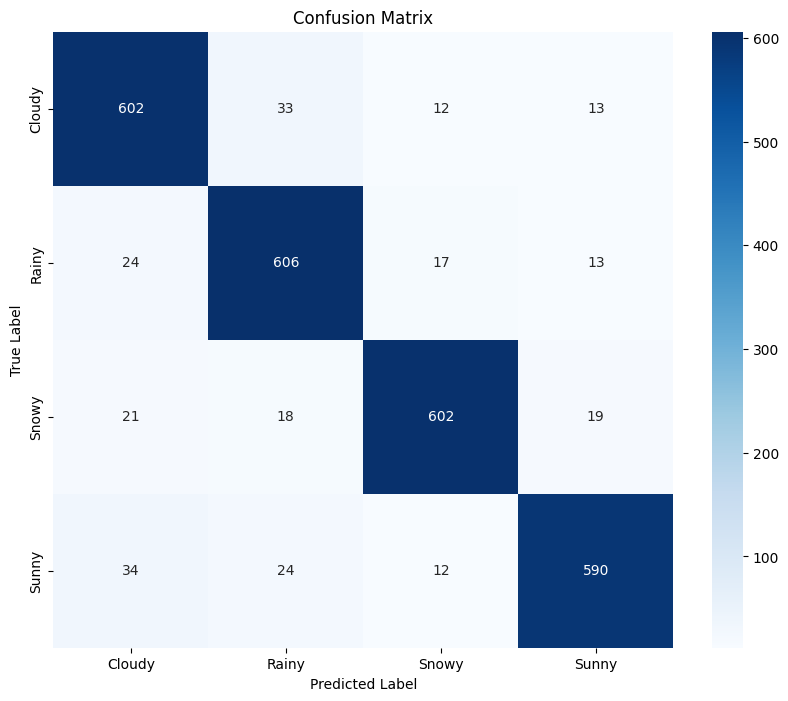

In [9]:
# Initialization
model = WeatherClassifier(input_dim=X_train.shape[1], hidden_dim=64, output_dim=len(le.classes_)).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Dataloaders dictionary
dataloaders = {"train": train_loader, "val": test_loader, "test": test_loader}
classes = list(le.classes_)

# Number of epochs
NUM_EPOCHS = 50

# Train the model
model, history = train_model(model, optimizer, criterion, dataloaders, num_epochs=NUM_EPOCHS)

# Evaluate the model
y_true, y_pred = evaluate_model(model, dataloaders, classes)

# Compute overall test accuracy
final_accuracy = sum(np.array(y_true) == np.array(y_pred)) / len(y_true)

### 10. Plot Learning Curve

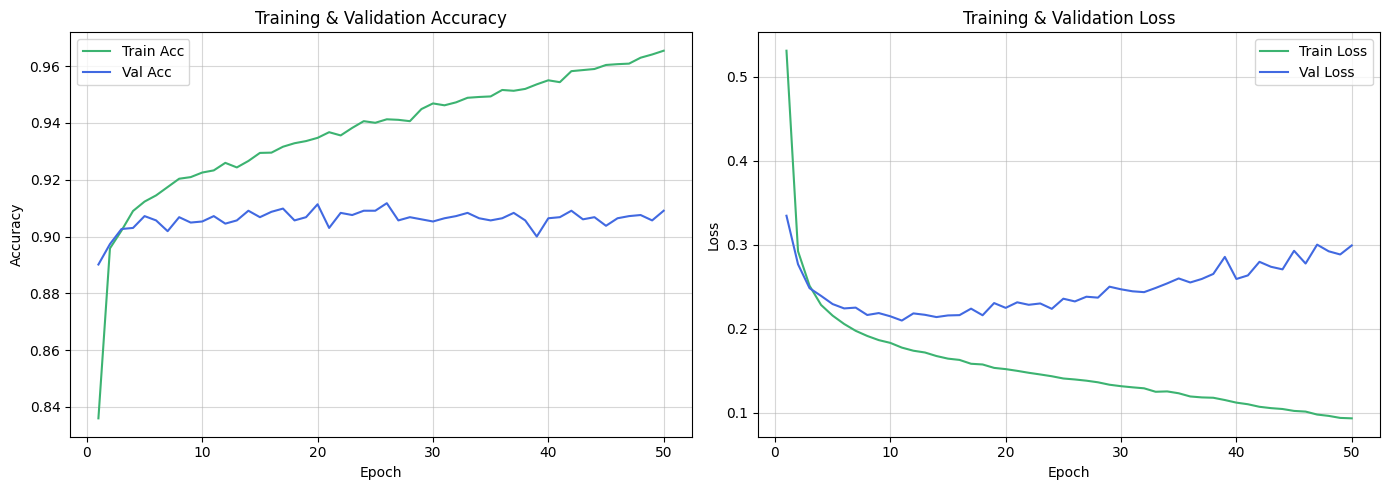

In [10]:
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    fig, axs = plt.subplots(1, 2, figsize=(14,5))

    # Accuracy
    axs[0].plot(epochs, history['train_acc'], label='Train Acc', color='mediumseagreen')
    axs[0].plot(epochs, history['val_acc'], label='Val Acc', color='royalblue')
    axs[0].set_title("Training & Validation Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()
    axs[0].grid(True, alpha=0.5)

    # Loss
    axs[1].plot(epochs, history['train_loss'], label='Train Loss', color='mediumseagreen')
    axs[1].plot(epochs, history['val_loss'], label='Val Loss', color='royalblue')
    axs[1].set_title("Training & Validation Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    axs[1].grid(True, alpha=0.5)

    plt.tight_layout()
    plt.show()
    
plot_training_curves(history)

### 11. Final Accuracy Bar Plot

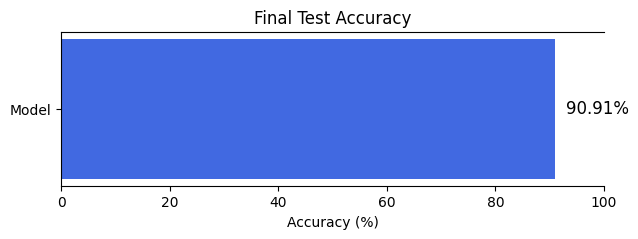

In [11]:
final_acc_percent = final_accuracy * 100

plt.figure(figsize=(7,2))
plt.barh(["Model"], [final_acc_percent], color="royalblue")
plt.gca().spines['right'].set_visible(False)
plt.xlim(0, 100)
plt.xlabel("Accuracy (%)")
plt.title("Final Test Accuracy")
plt.text(final_acc_percent + 2, 0, f"{final_acc_percent:.2f}%", va='center', fontsize=12)
plt.show()